## Combined ADCP and CTD particle test with CMEMS data

In [ ]:
from datetime import timedelta
from shapely.geometry import Point, Polygon
import numpy as np
import pyproj

from parcels import (
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

### Read sample input data

In [2]:
# Load the CMEMS data (3 days manually downloaded)
dataset_folder = "/nethome/0448257/Data"
filenames = {
    "U": f"{dataset_folder}/studentdata_UV.nc",
    "V": f"{dataset_folder}/studentdata_UV.nc",
    "S": f"{dataset_folder}/studentdata_S.nc",
    "T": f"{dataset_folder}/studentdata_T.nc"}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# add bathymetry data to the fieldset for CTD cast
bathymetry_file = f"{dataset_folder}/GLO-MFC_001_024_mask_bathy.nc"
bathymetry_variables = ('bathymetry', 'deptho')
bathymetry_dimensions = {'lon': 'longitude', 'lat': 'latitude'}
bathymetry_field = Field.from_netcdf(bathymetry_file, bathymetry_variables, bathymetry_dimensions)
fieldset.add_field(bathymetry_field)
# read in data already
fieldset.computeTimeChunk(0,1)

21600

In [3]:
# set initial location #TODO should be input to function or come from leafmap 
coords_input = [[-94.394531, -4.390229], [-106.523437, -0.175781], [-124.541016, -6.053161], [-140.537109, -0.527336]]

# check if input sample locations are within data availability area, only sample if so
poly = Polygon([(-170, 5), (-170, -10), (-75, -10), (-75, 5)])
coords = []
for coord in coords_input:
    if poly.contains(Point(coord)):
        coords.append(coord)

### Determine ship course as intermediate points between CTD stations

In [4]:
# Initialize lists to store intermediate points
sample_lons = []
sample_lats = []

# Loop over station coordinates and calculate intermediate points along great circle path
i = 0
for i in (range(len(coords)-1)):
    startlong = coords[i][0]
    startlat = coords[i][1]
    endlong = coords[i+1][0]
    endlat = coords[i+1][1]

    # calculate line string along path with segments every TODO hour or 5 min = 3.6*60*5 = 1080 m, for now 3 midpoints
    g = pyproj.Geod(ellps='WGS84')
    # r = g.inv_intermediate(startlong, startlat, endlong, endlat, del_s = 1080)
    r = g.inv_intermediate(startlong, startlat, endlong, endlat, initial_idx=0, return_back_azimuth=False, npts=3)
    # store all intermediate points
    sample_lons.append(r.lons) # stored as a list of arrays
    sample_lats.append(r.lats)

# initial_idx will add begin point to each list (but not end point to avoid dubbling) so add final endpoint manually
sample_lons = np.append(np.hstack(sample_lons), endlong)
sample_lats = np.append(np.hstack(sample_lats), endlat)

### Define particles and sampling functions 

In [5]:
# Create ADCP like particles to sample the ocean
class ADCPParticle(JITParticle):
    """Define a new particle class that does ADCP like measurements"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# define ADCP sampling function from Usample and Vsample (because of A grid)
def SampleVel(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)
    # particle.V = fieldset.V.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

# Create CTD like particles to sample the ocean
class CTDParticle(JITParticle):
    """Define a new particle class that does CTD like measurements"""
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)
    raising = Variable("raising", dtype=np.int32, initial=0.0)

# define function lowering and raising CTD
def CTDcast(particle, fieldset, time):
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    vertical_speed = 1.0  # sink and rise speed in m/s

    if particle.raising == 0:
        # Sinking with vertical_speed until near seafloor
        particle_ddepth = vertical_speed * particle.dt
        if particle.depth >= (seafloor - 3000): #TODO change back to 20
            particle.raising = 1

    if particle.raising == 1:
        # Rising with vertical_speed until depth is 5 m
        if particle.depth > 5:
            particle_ddepth = -vertical_speed * particle.dt  
            if particle.depth + particle_ddepth <= 5:
                # to break the loop ...
                particle.state = 41
                print("CTD cast finished")

# define function sampling Salinity
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

### Run simulation

In [25]:
# Create ADCP like particle set TODO accurate depths, 1000 m every 20 m = 50 particles
depthnum = 5
# Initiate ADCP like particle set
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=ADCPParticle, lon=np.full(depthnum,sample_lons[0]), lat=np.full(depthnum,sample_lats[0]), depth=np.linspace(5, 1005, num=depthnum), time=0
)
# create a ParticleFile to store the ADCP output
adcp_output_file = pset.ParticleFile(name="./results/sailship_adcp.zarr")
adcp_dt = timedelta(hours=1).total_seconds() # timestep of ADCP output

# initialize CTD station number and time 
total_time = timedelta(hours=0).total_seconds()
ctd = 0
ctd_dt = timedelta(seconds=10) # timestep of CTD output reflecting post-proces binning into 10m bins

# run the model for the length of the sample_lons list
for i in range(len(sample_lons)):

    # set the ADCP particle lon and lat
    pset.lon[:] = sample_lons[i]
    pset.lat[:] = sample_lats[i]
    print(sample_lats[i], sample_lons[i])

    # execute the kernels to sample U and V
    pset.execute(SampleVel, dt=adcp_dt, runtime=1, output_file=adcp_output_file)
    print(f"Writing time {pset.time[0]}")

    # check if we are at a CTD station
    if (sample_lons[i] - coords[ctd][0]) < 0.001 and (sample_lats[i] - coords[ctd][1]) < 0.001:
        print('CTD time!')
        ctd += 1
        
        # release CTD particle
        pset_CTD = ParticleSet(fieldset=fieldset, pclass=CTDParticle, lon=sample_lons[i], lat=sample_lats[i], depth=5, time=total_time)

        # create a ParticleFile to store the CTD output
        ctd_output_file = pset_CTD.ParticleFile(name=f"./results/CTD_test_{ctd}.zarr", outputdt=ctd_dt)

        # record the temperature and salinity of the particle
        pset_CTD.execute([SampleS, SampleT, CTDcast], runtime=timedelta(hours=2), dt=ctd_dt, output_file=ctd_output_file)
        total_time = pset_CTD.time[0]
        print(total_time)

    # update the particle time
    total_time += adcp_dt
    pset.time[:] = total_time
    print(total_time)


-4.390229 -94.394531
INFO: Output files are stored in ./results/sailship_adcp.zarr.
100%|██████████| 1.0/1.0 [00:00<00:00,  9.61it/s]
Writing time 0.0
CTD time!
INFO: Output files are stored in ./results/CTD_test_1.zarr.
 53%|█████▎    | 3790.0/7200.0 [00:40<00:38, 89.30it/s]CTD cast finished
 53%|█████▎    | 3790.0/7200.0 [00:41<00:36, 92.39it/s]
3790.0
7390.0
-2.9981073983713364 -98.44618049404214
INFO: Output files are stored in ./results/sailship_adcp.zarr.
100%|██████████| 1.0/1.0 [00:00<00:00, 12.33it/s]
Writing time 1.0
10990.0
-1.590929012736848 -102.48755119774967
INFO: Output files are stored in ./results/sailship_adcp.zarr.
100%|██████████| 1.0/1.0 [00:00<00:00, 16.41it/s]
Writing time 2.0
14590.0
-0.17578099999999997 -106.523437
INFO: Output files are stored in ./results/sailship_adcp.zarr.
100%|██████████| 1.0/1.0 [00:00<00:00, 16.11it/s]
Writing time 3.0
CTD time!
INFO: Output files are stored in ./results/CTD_test_2.zarr.
 55%|█████▌    | 3990.0/7200.0 [00:43<00:36, 87.5

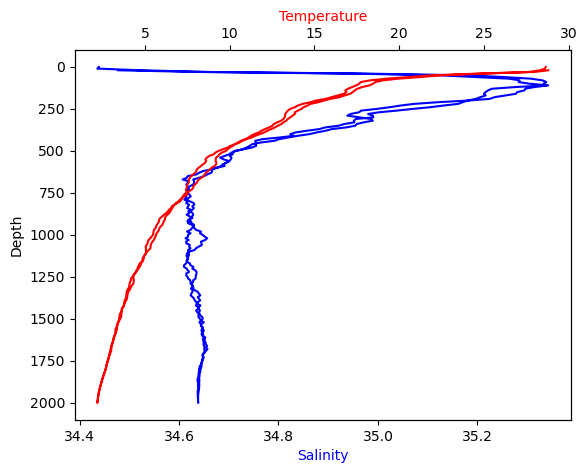

In [69]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open output and read to x, y, z
ds = xr.open_zarr("./results/CTD_test_2.zarr")
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
time = ds["time"][:].squeeze()
T = ds["temperature"][:].squeeze()
S = ds["salinity"][:].squeeze()
ds.close()

# add some noise
from scipy.ndimage import uniform_filter1d
random_walk = np.random.random()/10
z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
t_norm = np.linspace(0, 1, num=len(time))
dS = abs(np.append(0, np.diff(S))) # scale noise with gradient
for i in range(5, 0, -1):
    dS[dS<1*10**-i] = 0.5-i/10
S = S + uniform_filter1d(np.random.random(S.shape)*dS*(1-z_norm) + random_walk*(np.max(S).values - np.min(S).values)*(1-z_norm)*t_norm, 10)
T = T + uniform_filter1d(np.random.random(T.shape)*5*(1-z_norm) - random_walk/2*(np.max(T).values - np.min(T).values)*(1-z_norm)*t_norm, 25)

# TS plot
fig, ax1 = plt.subplots(1,1)
ax1.plot(S, z, color="b")
ax1.invert_yaxis()
ax1.set_xlabel('Salinity', color = "b")
ax1.set_ylabel('Depth')
ax2 = ax1.twiny() # ax1 and ax2 share y-axis
ax2.plot(T, z, color="r") 
ax2.set_xlabel('Temperature', color = "r")
plt.show()

In [65]:
# reshaping data to export to csv
header = f"'z','temperature', 'salinity'"
data = np.column_stack((z,T,S))
new_line = '\n'
np.savetxt('./results/CTD_test.csv', data, header=header, delimiter=',', comments=f'{x.attrs} {x[0].values}{new_line}{y.attrs}{y[0].values}{new_line}start time: {time[0].values}{new_line}end time: {time[-1].values}{new_line}')

# Read back in... student example
z, T, S = np.loadtxt('./results/CTD_test.csv', delimiter=',', skiprows=5, unpack=True)


### Do some plotting to check output

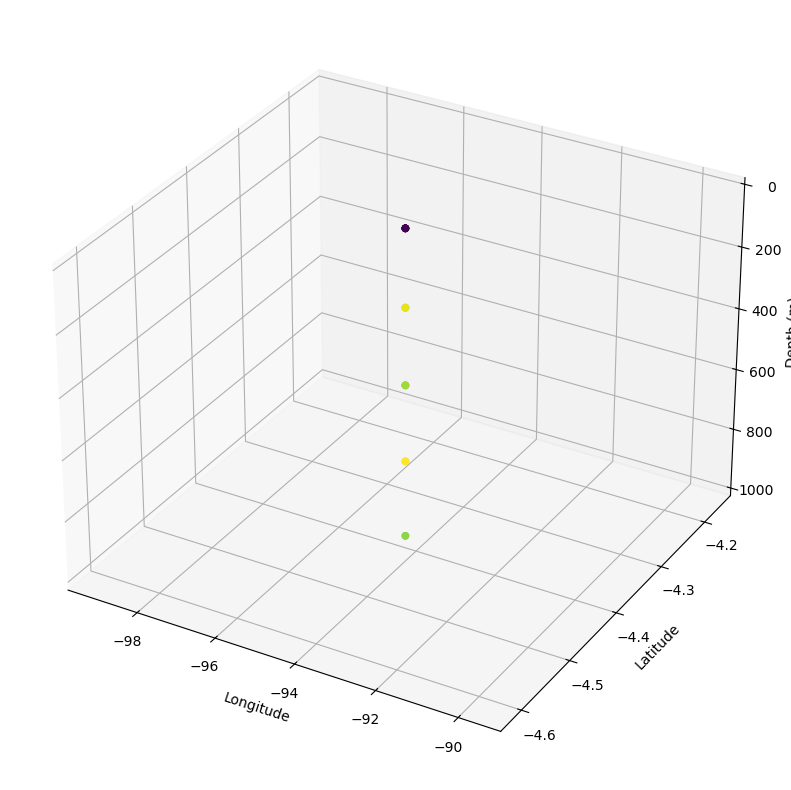

In [70]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Open output and read to x, y, z
ds = xr.open_zarr("./results/sailship_adcp.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [13]:
print(ds.lat.values)

[[-4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229
  -4.390229 -4.390229 -4.390229]
 [-4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229
  -4.390229 -4.390229 -4.390229]
 [-4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229
  -4.390229 -4.390229 -4.390229]
 [-4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229
  -4.390229 -4.390229 -4.390229]
 [-4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229 -4.390229
  -4.390229 -4.390229 -4.390229]]


### Plot CTD casts

In [3]:
import xarray as xr
# Open and combine the CTD output files
da = xr.open_zarr("./results/CTD_test_1.zarr")
for i in range(2, ctd+1):
    da = xr.concat([da, xr.open_zarr(f"./results/CTD_test_{i}.zarr")], "obs")
# Write the combined output to a netcdf file
da.to_netcdf("./results/CTD_test.nc", mode="w")
da.close()

NameError: name 'ctd' is not defined

ValueError: 'c' argument has 64 elements, which is inconsistent with 'x' and 'y' with size 16.

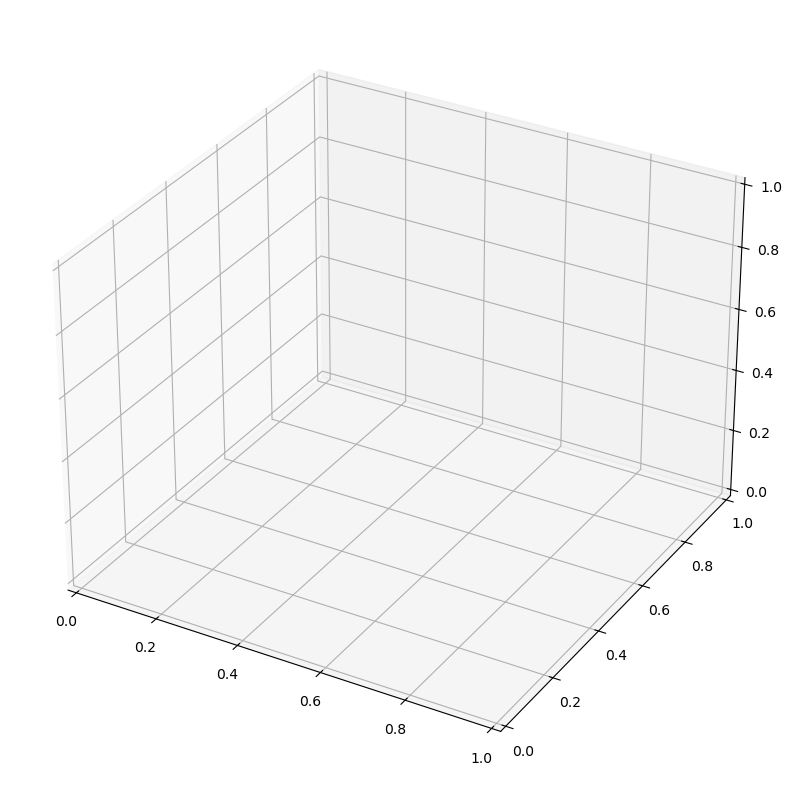

In [18]:
# Open output and read to x, y, z
ds = xr.open_dataset("./results/CTD_test.nc")
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
T = ds["temperature"][:].squeeze()
S = ds["salinity"][:].squeeze()
# salinity = ds["salinity"][:].squeeze()
# temperature = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=T, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [ ]:

da = xr.open_zarr("CTD_test_2.zarr")
print(da)
da.close()
print(ctd)

<xarray.Dataset>
Dimensions:     (trajectory: 1, obs: 1)
Coordinates:
  * obs         (obs) int32 0
  * trajectory  (trajectory) int64 32
Data variables:
    U           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    V           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2
3
